In [ ]:
!pip install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.api as sm

# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Prepare data
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Convert target to binary
y_binary = (y['Diagnosis'] == 'M').astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_binary, test_size=0.2, random_state=42)

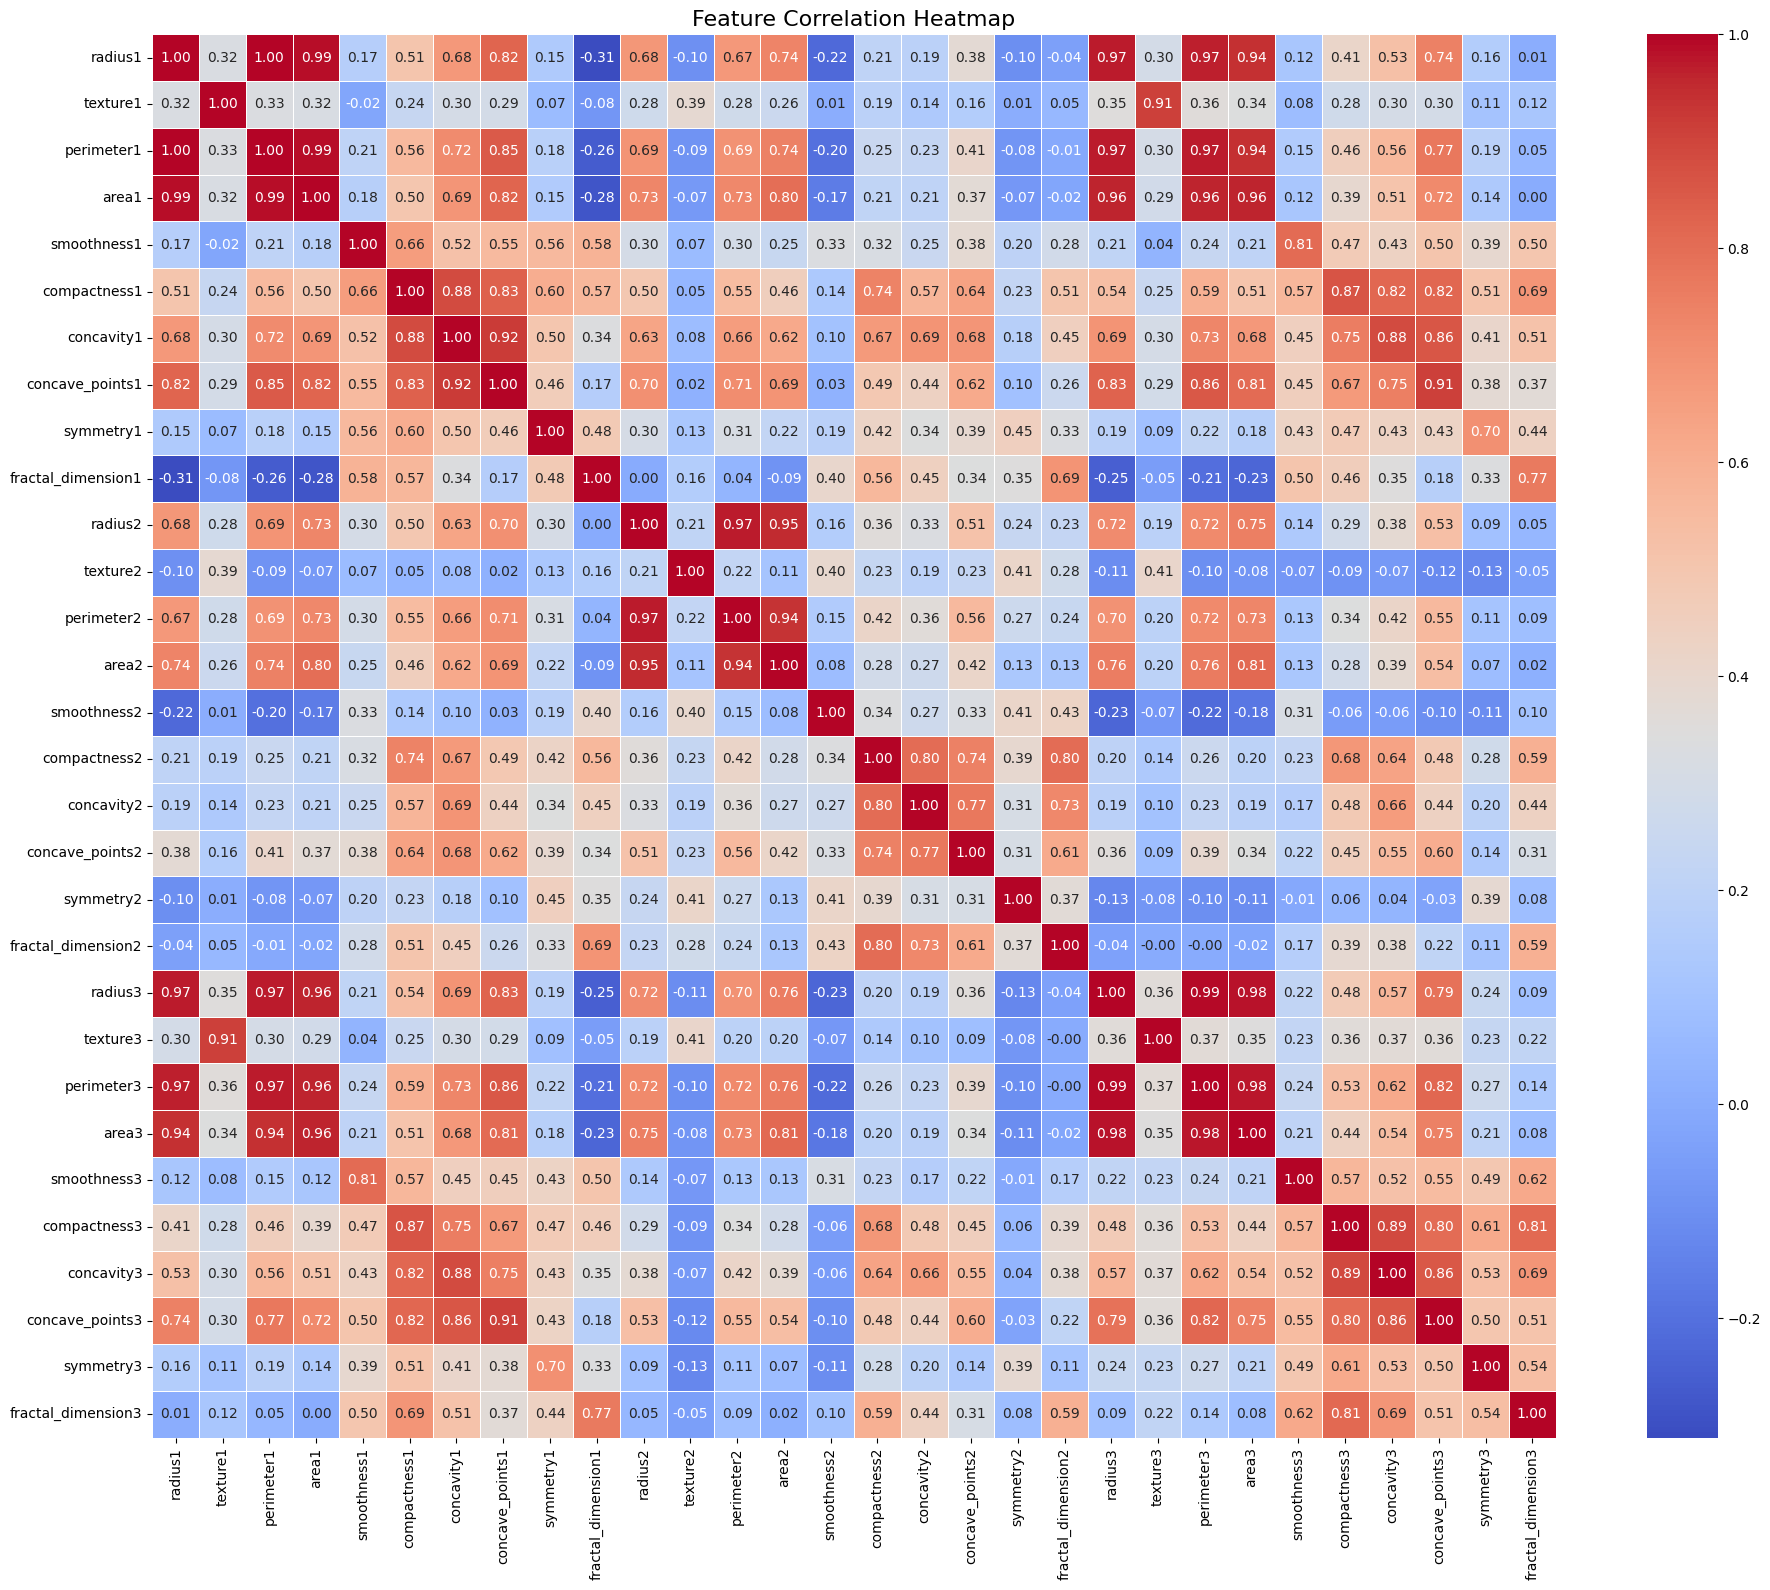

In [ ]:
# 1. Correlation Heatmap
plt.figure(figsize=(20, 16))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()
plt.close()



In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 1. Logistic Regression with Regularization
lr = LogisticRegression(penalty='l2', C=1.0, random_state=42, solver='liblinear')  # L2 regularization
lr.fit(X_train_scaled, y_train)

# Coefficients
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(lr.coef_[0])
}).sort_values(by='importance', ascending=False)

# Display Feature Importance
print(feature_importance)

               feature  importance
21            texture3    1.335651
10             radius2    1.283117
28           symmetry3    1.196087
7      concave_points1    1.130510
13               area2    0.944861
26          concavity3    0.942150
23               area3    0.882949
20             radius3    0.881042
6           concavity1    0.818323
27     concave_points3    0.766904
15        compactness2    0.700516
12          perimeter2    0.619228
19  fractal_dimension2    0.592525
22          perimeter3    0.591928
5         compactness1    0.552881
24         smoothness3    0.550488
18           symmetry2    0.481653
3                area1    0.475932
0              radius1    0.408658
1             texture1    0.388074
2           perimeter1    0.372161
14         smoothness2    0.321311
17     concave_points2    0.285207
8            symmetry1    0.231279
11            texture2    0.192011
16          concavity2    0.188007
29  fractal_dimension3    0.162618
4          smoothnes

In [ ]:
# 2. Statsmodels GLM with Reduced Features
# Check multicollinearity (remove highly correlated features)
corr_matrix = pd.DataFrame(X_train_scaled, columns=X.columns).corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Reset indices for consistency
X_train_reduced = X_train_reduced.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Add constant term to X_train_reduced
X_train_reduced_sm = sm.add_constant(X_train_reduced)

# Fit GLM with aligned data
glm_model = sm.GLM(y_train, X_train_reduced_sm, family=sm.families.Binomial())
glm_results = glm_model.fit()

# Print summary
print(glm_results.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:              Diagnosis   No. Observations:                  455
Model:                            GLM   Df Residuals:                      434
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15.923
Date:                Sat, 30 Nov 2024   Deviance:                       31.845
Time:                        08:05:19   Pearson chi2:                     34.3
No. Iterations:                    13   Pseudo R-squ. (CS):             0.7133
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.6317      1

# **Significant Variables (P-value < 0.05):**

**radius1 (coef = 10.6143):** Strong positive association; larger radius increases the probability of the diagnosis.

**texture1 (coef = 6.6298)**: Positive association; higher texture values increase probability.

**compactness1 (coef = -23.5063):**  Strong negative association; higher compactness decreases the probability.

**concavity1 (coef = 14.3093):** Strong positive association; higher concavity increases the probability.

**symmetry1 (coef = -5.3852):** Negative association; higher symmetry decreases the probability.

**radius2 (coef = 13.3728):** Positive association; larger radius increases the probability.

**concavity2 (coef = -13.3533):** Strong negative association; higher concavity decreases the probability.

**concave_points2 (coef = 13.6659):** Positive association; more concave points increase the probability.

**symmetry2 (coef = -9.3710):** Negative association; higher symmetry decreases the probability.

**symmetry3 (coef = 15.9732):** Positive association; higher symmetry increases the probability.

<Figure size 1600x1200 with 0 Axes>

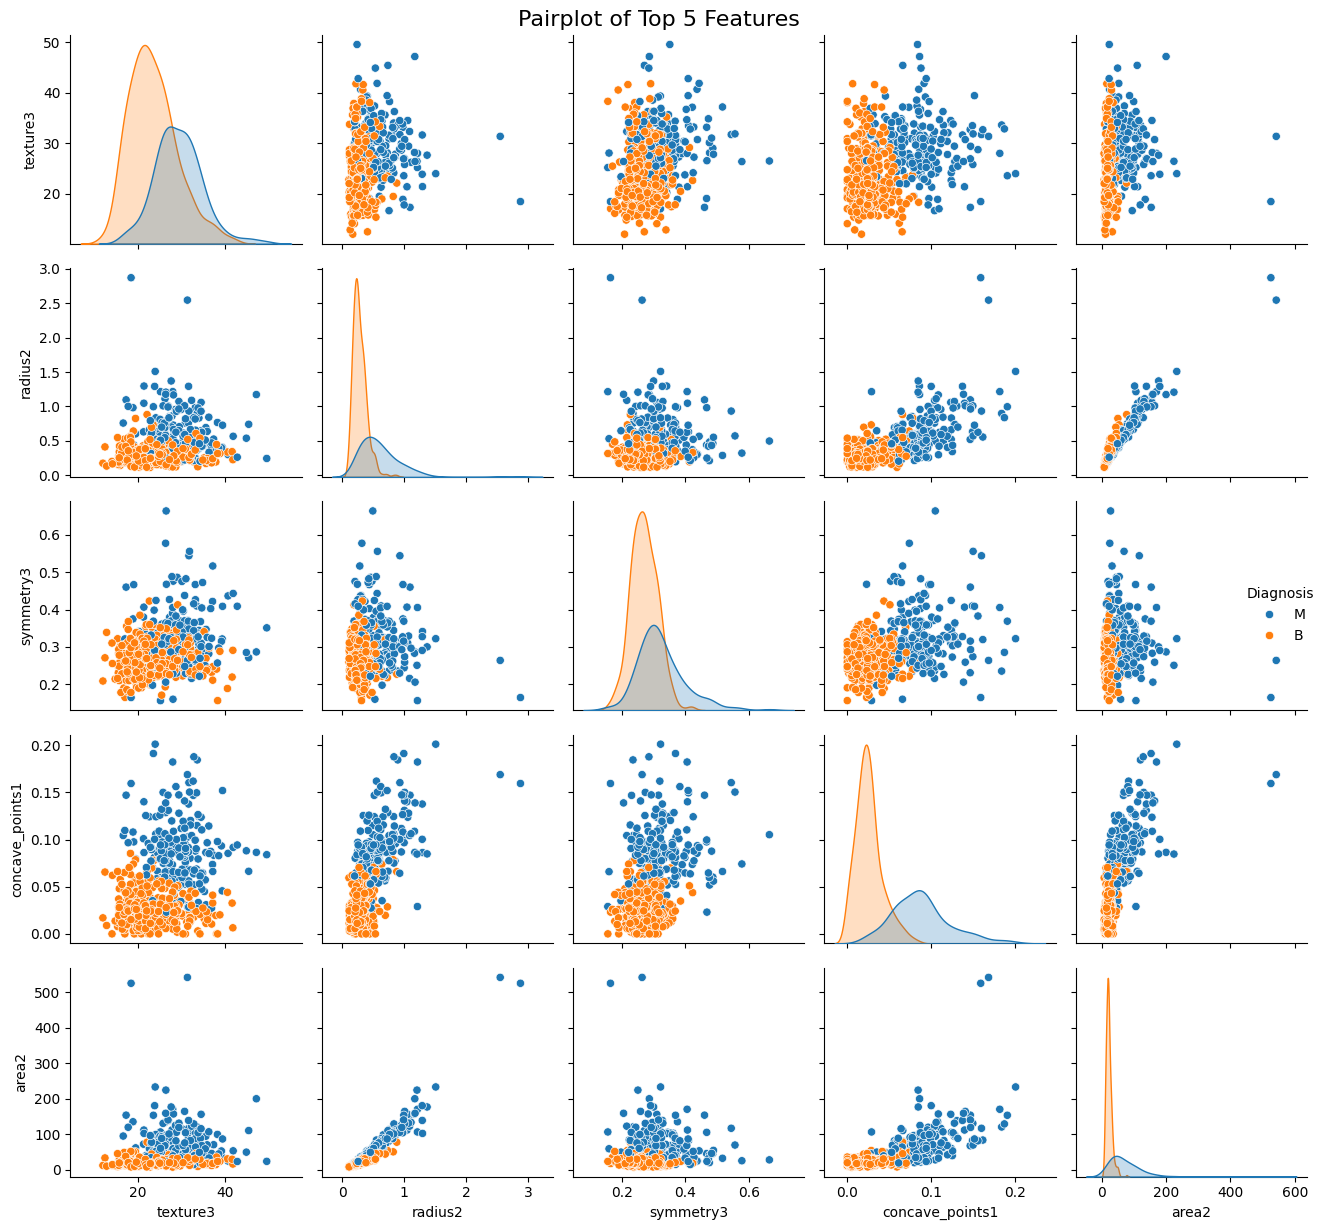

In [ ]:
# 4. Pairplot of top features
top_features = feature_importance['feature'][:5].tolist()
plt.figure(figsize=(16, 12))
sns.pairplot(X[top_features].join(y), hue='Diagnosis')
plt.suptitle('Pairplot of Top 5 Features', fontsize=16)
plt.tight_layout()
plt.savefig('top_features_pairplot.png')
plt.show()
plt.close()

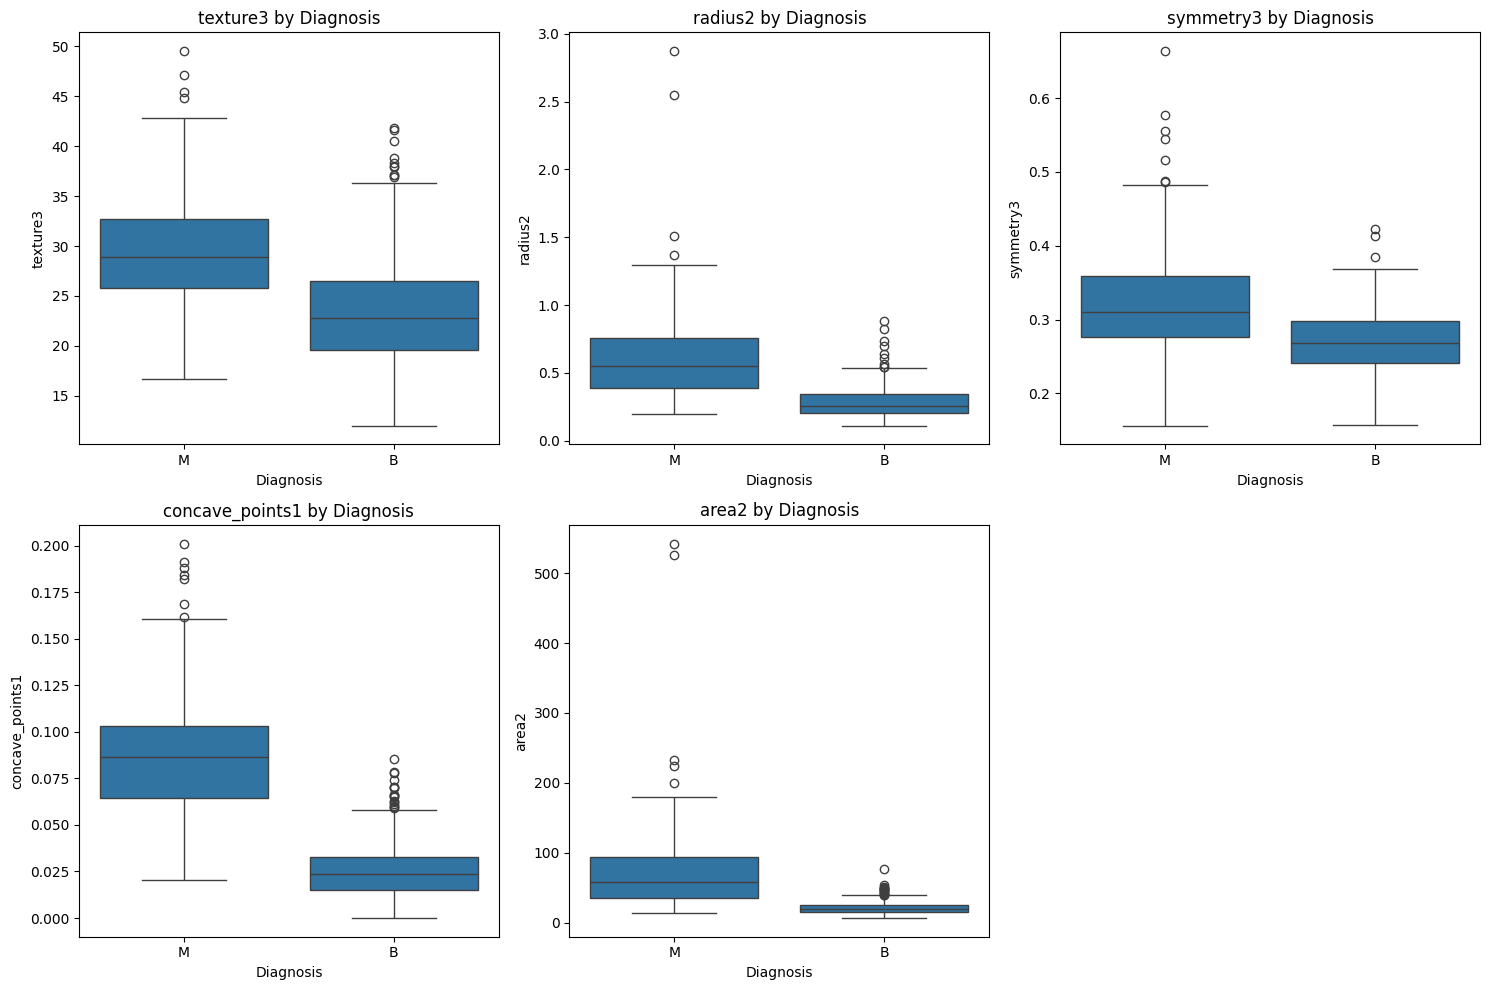

In [ ]:
# 5. Box plots of top features by Diagnosis
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Diagnosis', y=feature, data=X.join(y))
    plt.title(f'{feature} by Diagnosis')
plt.tight_layout()
plt.savefig('boxplots_by_Diagnosis.png')
plt.show()
plt.close()

In [ ]:
# 6. Performance Metrics
y_pred = lr.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


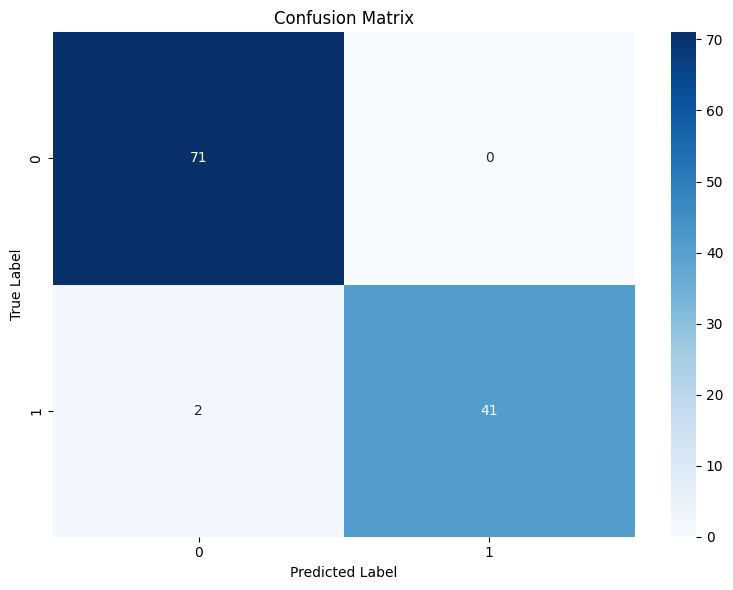

In [ ]:
# 7. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()